In [1]:
!pip install roboflow pycocotools matplotlib opencv-python pandas


In [2]:
from roboflow import Roboflow

rf = Roboflow(api_key="ijp1CpxrIPTwscQJxiOz")
project = rf.workspace("field-q4yun").project("field-ejmw3")
version = project.version(8)
dataset = version.download("coco-segmentation")

print(f"\nDataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...

Dataset downloaded to: /home/jupyter/Sam2 Model/field-8


In [3]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd segment-anything-2
!pip install -e 

fatal: destination path 'segment-anything-2' already exists and is not an empty directory.
/home/jupyter/Sam2 Model/segment-anything-2


This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.



Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

-e option requires 1 argument


In [4]:
!wget -q -O sam2_hiera_tiny.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt"
print("Downloaded: sam2_hiera_tiny.pt")

import os
print(f"File size: {os.path.getsize('sam2_hiera_tiny.pt') / 1024 / 1024:.1f} MB")

Downloaded: sam2_hiera_tiny.pt
File size: 148.7 MB


In [5]:
import torch

print("="*50)
print("GPU Information")
print("="*50)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    props = torch.cuda.get_device_properties(i)
    print(f"\nGPU {i}: {props.name}")
    print(f"  Memory: {props.total_memory / 1024**3:.1f} GB")
    print(f"  Compute Capability: {props.major}.{props.minor}")

GPU Information
PyTorch version: 2.7.1+cu118
CUDA available: True
Number of GPUs: 2

GPU 0: Tesla T4
  Memory: 14.6 GB
  Compute Capability: 7.5

GPU 1: Tesla T4
  Memory: 14.6 GB
  Compute Capability: 7.5


In [6]:
import os
import json
import random
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

print("All imports successful!")

All imports successful!


In [7]:
class Config:
    # === Paths ===
    DATASET_DIR = "../field-8"  # ปรับตาม path ที่ download มา
    TRAIN_DIR = os.path.join(DATASET_DIR, "train")
    VALID_DIR = os.path.join(DATASET_DIR, "valid")
    TEST_DIR = os.path.join(DATASET_DIR, "test")
    
    # === Model ===
    SAM2_CHECKPOINT = "./sam2_hiera_tiny.pt"
    MODEL_CFG = "sam2_hiera_t.yaml"
    
    # === Training ===
    NUM_STEPS = 3000
    LEARNING_RATE = 5e-5
    WEIGHT_DECAY = 1e-4
    ACCUMULATION_STEPS = 4
    
    # === Scheduler ===
    SCHEDULER_STEP = 1000
    SCHEDULER_GAMMA = 0.5
    
    # === Output ===
    MODEL_NAME = "sam2_field"
    SAVE_EVERY = 500
    LOG_EVERY = 50
    
    # === Device ===
    DEVICE = "cuda:0"
    
    SEED = 42

config = Config()

# Verify paths
print("Checking paths...")
print(f"Train dir exists: {os.path.exists(config.TRAIN_DIR)}")
print(f"Valid dir exists: {os.path.exists(config.VALID_DIR)}")
print(f"Test dir exists: {os.path.exists(config.TEST_DIR)}")
print(f"SAM2 checkpoint exists: {os.path.exists(config.SAM2_CHECKPOINT)}")

Checking paths...
Train dir exists: True
Valid dir exists: True
Test dir exists: True
SAM2 checkpoint exists: True


In [8]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

set_seeds(config.SEED)
print(f"Seeds set to {config.SEED}")

Seeds set to 42


In [9]:
class COCOFieldDataset:
    """Dataset loader สำหรับ COCO format จาก Roboflow"""
    
    def __init__(self, data_dir, annotation_file="_annotations.coco.json"):
        self.data_dir = data_dir
        self.annotation_path = os.path.join(data_dir, annotation_file)
        
        # Load COCO annotations
        self.coco = COCO(self.annotation_path)
        self.image_ids = list(self.coco.imgs.keys())
        
        print(f"Loaded {len(self.image_ids)} images from {data_dir}")
        categories = [cat['name'] for cat in self.coco.cats.values()]
        print(f"Categories: {categories}")
    
    def __len__(self):
        return len(self.image_ids)
    
    def get_sample(self, idx=None):
        """ดึงข้อมูล 1 sample"""
        if idx is None:
            idx = random.randint(0, len(self.image_ids) - 1)
        
        img_id = self.image_ids[idx]
        img_info = self.coco.imgs[img_id]
        
        # Load image
        img_path = os.path.join(self.data_dir, img_info['file_name'])
        image = cv2.imread(img_path)
        if image is None:
            return None, None, None, 0
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        if len(anns) == 0:
            return None, None, None, 0
        
        # Create combined binary mask
        h, w = image.shape[:2]
        combined_mask = np.zeros((h, w), dtype=np.uint8)
        
        for ann in anns:
            if 'segmentation' in ann:
                if isinstance(ann['segmentation'], list):
                    rle = maskUtils.frPyObjects(ann['segmentation'], h, w)
                    mask = maskUtils.decode(rle)
                    if len(mask.shape) == 3:
                        mask = mask.sum(axis=2)
                    mask = (mask > 0).astype(np.uint8)
                else:
                    mask = maskUtils.decode(ann['segmentation'])
                combined_mask = np.maximum(combined_mask, mask)
        
        # Resize to 1024
        scale = min(1024 / w, 1024 / h)
        new_w, new_h = int(w * scale), int(h * scale)
        
        image = cv2.resize(image, (new_w, new_h))
        combined_mask = cv2.resize(combined_mask, (new_w, new_h), 
                                   interpolation=cv2.INTER_NEAREST)
        
        # Sample points
        points = self._sample_points(combined_mask, num_points=3)
        if points is None:
            return None, None, None, 0
        
        # Reshape
        mask_tensor = combined_mask[np.newaxis, :, :]
        points_tensor = points[:, np.newaxis, :]
        
        return image, mask_tensor, points_tensor, len(points)
    
    def _sample_points(self, mask, num_points=3):
        """สุ่ม points จากภายใน mask"""
        eroded = cv2.erode(mask, np.ones((5, 5), np.uint8), iterations=1)
        coords = np.argwhere(eroded > 0)
        
        if len(coords) == 0:
            coords = np.argwhere(mask > 0)
        if len(coords) == 0:
            return None
        
        num_points = min(num_points, len(coords))
        indices = np.random.choice(len(coords), num_points, replace=False)
        
        points = []
        for idx in indices:
            y, x = coords[idx]
            points.append([x, y])
        
        return np.array(points)

print("Dataset class defined!")

Dataset class defined!


In [10]:
print("Loading datasets...")
train_dataset = COCOFieldDataset(config.TRAIN_DIR)
valid_dataset = COCOFieldDataset(config.VALID_DIR)

print(f"\nTotal: {len(train_dataset)} train, {len(valid_dataset)} valid")


Loading datasets...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loaded 134 images from ../field-8/train
Categories: ['1', '1']
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loaded 29 images from ../field-8/valid
Categories: ['1', '1']

Total: 134 train, 29 valid


=== Training Samples ===


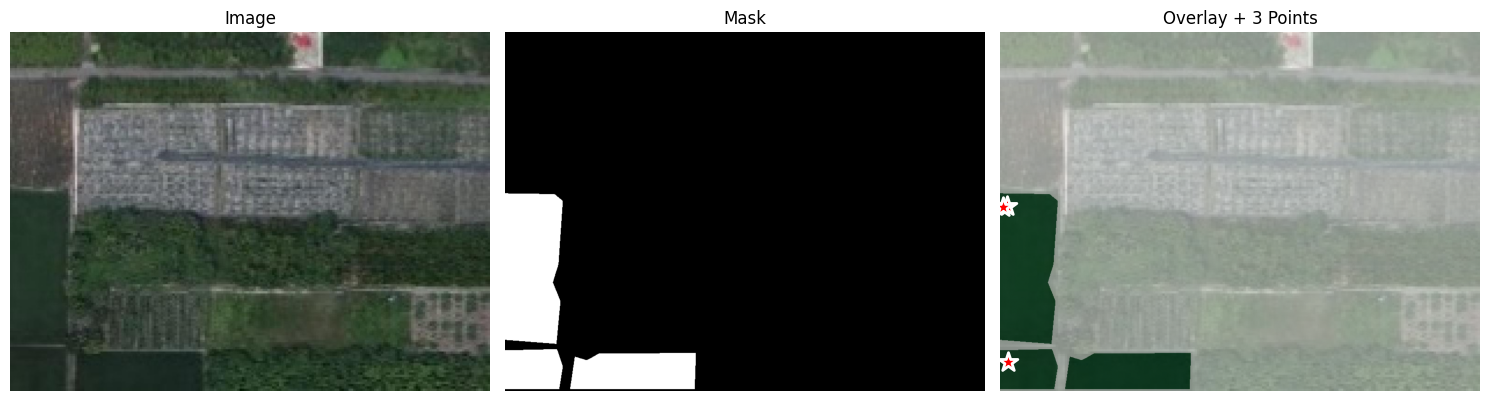

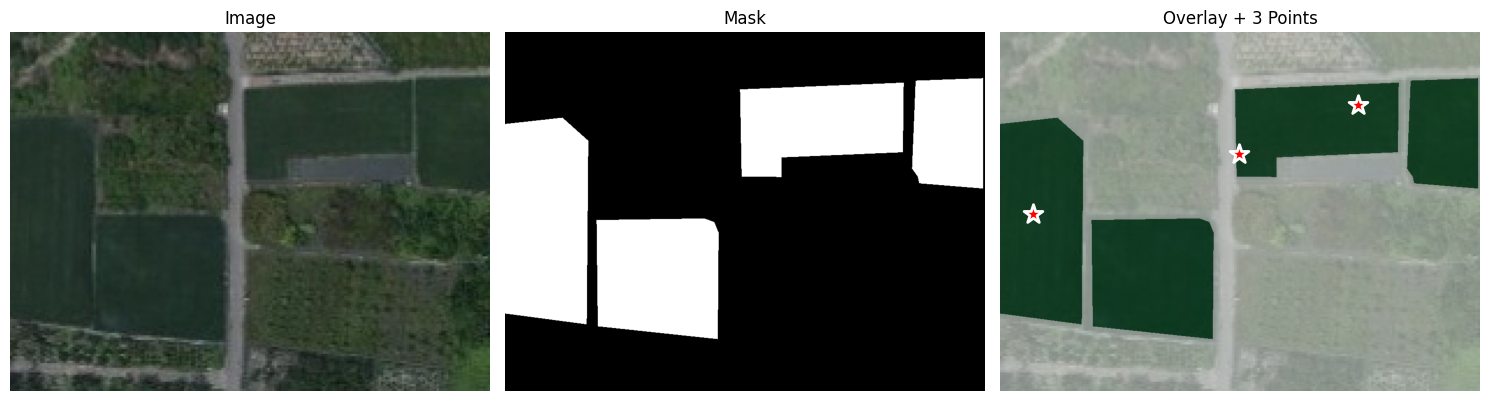

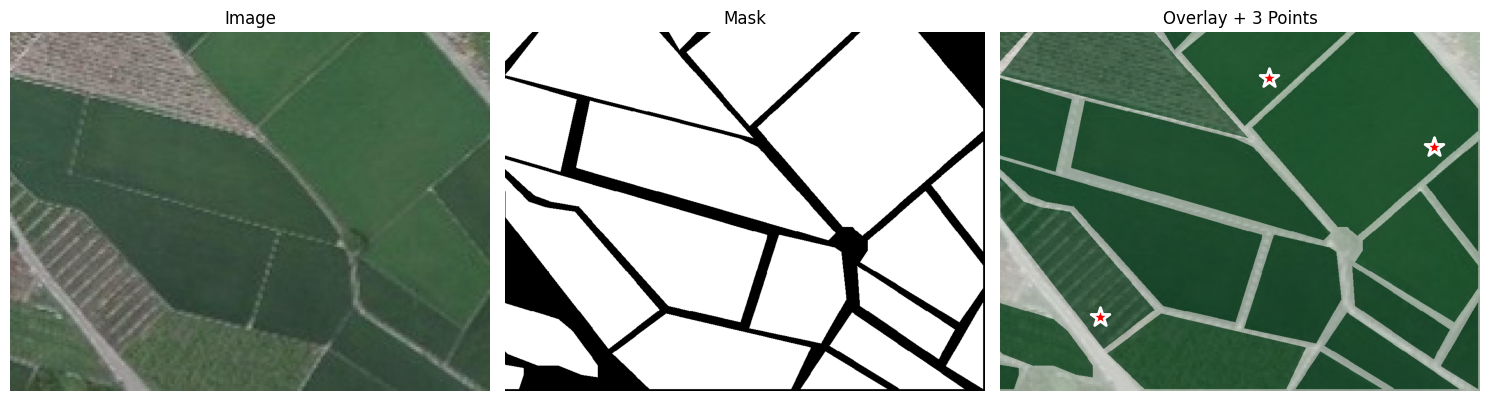

In [11]:
def visualize_sample(dataset, idx=None):
    """แสดงตัวอย่างข้อมูล"""
    image, mask, points, num_points = dataset.get_sample(idx)
    
    if image is None:
        print("Could not load sample")
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis('off')
    
    axes[1].imshow(mask[0], cmap='gray')
    axes[1].set_title("Mask")
    axes[1].axis('off')
    
    axes[2].imshow(image)
    axes[2].imshow(mask[0], alpha=0.5, cmap='Greens')
    points_2d = points[:, 0, :]
    for pt in points_2d:
        axes[2].scatter(pt[0], pt[1], c='red', s=200, marker='*',
                       edgecolors='white', linewidths=2)
    axes[2].set_title(f"Overlay + {num_points} Points")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# แสดง 3 ตัวอย่าง
print("=== Training Samples ===")
for i in range(3):
    visualize_sample(train_dataset)

In [12]:
def setup_model(config):
    """สร้างและตั้งค่า SAM2 model"""
    print(f"Loading SAM2 model on {config.DEVICE}...")
    
    sam2_model = build_sam2(config.MODEL_CFG, config.SAM2_CHECKPOINT, 
                            device=config.DEVICE)
    predictor = SAM2ImagePredictor(sam2_model)
    
    # Training mode
    predictor.model.sam_mask_decoder.train(True)
    predictor.model.sam_prompt_encoder.train(True)
    
    # Freeze image encoder
    for param in predictor.model.image_encoder.parameters():
        param.requires_grad = False
    
    # Count parameters
    trainable = sum(p.numel() for p in predictor.model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in predictor.model.parameters())
    
    print(f"Total parameters: {total:,}")
    print(f"Trainable parameters: {trainable:,}")
    print(f"Frozen parameters: {total - trainable:,}")
    
    return predictor

predictor = setup_model(config)
print("\nModel ready!")

Loading SAM2 model on cuda:0...
Total parameters: 38,945,986
Trainable parameters: 11,726,850
Frozen parameters: 27,219,136

Model ready!


In [13]:
def train_step(predictor, dataset, optimizer, scaler, step, running_iou, config):
    """Training step 1 iteration"""
    
    image, mask, points, num_points = dataset.get_sample()
    
    if image is None or num_points == 0:
        return running_iou
    
    with torch.amp.autocast(device_type='cuda'):
        labels = np.ones((num_points, 1))
        
        predictor.set_image(image)
        
        mask_input, unnorm_coords, labels_tensor, _ = predictor._prep_prompts(
            points, labels, box=None, mask_logits=None, normalize_coords=True
        )
        
        if unnorm_coords is None or unnorm_coords.shape[0] == 0:
            return running_iou
        
        sparse_emb, dense_emb = predictor.model.sam_prompt_encoder(
            points=(unnorm_coords, labels_tensor), boxes=None, masks=None
        )
        
        batched_mode = unnorm_coords.shape[0] > 1
        high_res_feats = [f[-1].unsqueeze(0) for f in predictor._features["high_res_feats"]]
        
        low_res_masks, pred_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_emb,
            dense_prompt_embeddings=dense_emb,
            multimask_output=True,
            repeat_image=batched_mode,
            high_res_features=high_res_feats,
        )
        
        pred_masks = predictor._transforms.postprocess_masks(
            low_res_masks, predictor._orig_hw[-1]
        )
        
        gt_mask = torch.tensor(mask.astype(np.float32), device=config.DEVICE)
        pred_mask = torch.sigmoid(pred_masks[:, 0])
        
        # BCE Loss
        seg_loss = (
            -gt_mask * torch.log(pred_mask + 1e-6)
            - (1 - gt_mask) * torch.log(1 - pred_mask + 1e-6)
        ).mean()
        
        # IoU
        intersection = (gt_mask * (pred_mask > 0.5)).sum(dim=(1, 2))
        union = gt_mask.sum(dim=(1, 2)) + (pred_mask > 0.5).sum(dim=(1, 2)) - intersection
        iou = (intersection / (union + 1e-6)).mean()
        
        # Score loss
        score_loss = torch.abs(pred_scores[:, 0] - iou).mean()
        
        # Total loss
        loss = seg_loss + score_loss * 0.05
        loss = loss / config.ACCUMULATION_STEPS
    
    scaler.scale(loss).backward()
    
    if step % config.ACCUMULATION_STEPS == 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
    
    running_iou = running_iou * 0.95 + 0.05 * iou.item()
    
    return running_iou

print("Train step function defined!")

Train step function defined!


In [14]:
def validate(predictor, dataset, config, num_samples=20):
    """Validation"""
    predictor.model.eval()
    ious = []
    
    with torch.no_grad():
        for _ in range(num_samples):
            image, mask, points, num_points = dataset.get_sample()
            
            if image is None or num_points == 0:
                continue
            
            with torch.amp.autocast(device_type='cuda'):
                labels = np.ones((num_points, 1))
                
                predictor.set_image(image)
                
                mask_input, unnorm_coords, labels_tensor, _ = predictor._prep_prompts(
                    points, labels, box=None, mask_logits=None, normalize_coords=True
                )
                
                if unnorm_coords is None:
                    continue
                
                sparse_emb, dense_emb = predictor.model.sam_prompt_encoder(
                    points=(unnorm_coords, labels_tensor), boxes=None, masks=None
                )
                
                batched_mode = unnorm_coords.shape[0] > 1
                high_res_feats = [f[-1].unsqueeze(0) for f in predictor._features["high_res_feats"]]
                
                low_res_masks, _, _, _ = predictor.model.sam_mask_decoder(
                    image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                    image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_emb,
                    dense_prompt_embeddings=dense_emb,
                    multimask_output=True,
                    repeat_image=batched_mode,
                    high_res_features=high_res_feats,
                )
                
                pred_masks = predictor._transforms.postprocess_masks(
                    low_res_masks, predictor._orig_hw[-1]
                )
                
                gt_mask = torch.tensor(mask.astype(np.float32), device=config.DEVICE)
                pred_mask = torch.sigmoid(pred_masks[:, 0])
                
                intersection = (gt_mask * (pred_mask > 0.5)).sum()
                union = gt_mask.sum() + (pred_mask > 0.5).sum() - intersection
                iou = (intersection / (union + 1e-6)).item()
                ious.append(iou)
    
    predictor.model.sam_mask_decoder.train(True)
    predictor.model.sam_prompt_encoder.train(True)
    
    return np.mean(ious) if ious else 0.0

print("Validation function defined!")

Validation function defined!


In [15]:
def train_model(predictor, train_dataset, valid_dataset, config):
    """Main training loop"""
    
    optimizer = torch.optim.AdamW(
        [p for p in predictor.model.parameters() if p.requires_grad],
        lr=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY
    )
    
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=config.SCHEDULER_STEP,
        gamma=config.SCHEDULER_GAMMA
    )
    
    scaler = torch.amp.GradScaler()
    
    history = {'train_iou': [], 'valid_iou': [], 'steps': []}
    
    train_iou = 0.0
    best_valid_iou = 0.0
    
    print("=" * 60)
    print(f"Starting training for {config.NUM_STEPS} steps")
    print(f"Train: {len(train_dataset)} | Valid: {len(valid_dataset)} images")
    print("=" * 60)
    
    for step in range(1, config.NUM_STEPS + 1):
        train_iou = train_step(
            predictor, train_dataset, optimizer, scaler, 
            step, train_iou, config
        )
        
        scheduler.step()
        
        # Logging
        if step % config.LOG_EVERY == 0:
            valid_iou = validate(predictor, valid_dataset, config, num_samples=10)
            
            lr = optimizer.param_groups[0]['lr']
            print(f"Step {step:4d}/{config.NUM_STEPS} | "
                  f"Train IoU: {train_iou:.4f} | "
                  f"Valid IoU: {valid_iou:.4f} | "
                  f"LR: {lr:.2e}")
            
            history['train_iou'].append(train_iou)
            history['valid_iou'].append(valid_iou)
            history['steps'].append(step)
            
            if valid_iou > best_valid_iou:
                best_valid_iou = valid_iou
                torch.save(predictor.model.state_dict(), 
                          f"{config.MODEL_NAME}_best.pt")
                print(f"  ✓ New best model saved! (IoU: {best_valid_iou:.4f})")
        
        # Save checkpoint
        if step % config.SAVE_EVERY == 0:
            torch.save(predictor.model.state_dict(), 
                      f"{config.MODEL_NAME}_step{step}.pt")
            print(f"  → Checkpoint saved: {config.MODEL_NAME}_step{step}.pt")
    
    # Final save
    torch.save(predictor.model.state_dict(), f"{config.MODEL_NAME}_final.pt")
    
    print("\n" + "=" * 60)
    print("Training Complete!")
    print(f"Best Valid IoU: {best_valid_iou:.4f}")
    print("=" * 60)
    
    return history

print("Training function defined!")

Training function defined!


In [21]:
def validate(predictor, dataset, config, num_samples=20):
    """Validation - Fixed version"""
    predictor.model.eval()
    ious = []
    
    with torch.no_grad():
        for _ in range(num_samples):
            image, mask, points, num_points = dataset.get_sample()
            
            if image is None or num_points == 0:
                continue
            
            with torch.amp.autocast(device_type='cuda'):
                labels = np.ones((num_points, 1))
                
                predictor.set_image(image)
                
                mask_input, unnorm_coords, labels_tensor, _ = predictor._prep_prompts(
                    points, labels, box=None, mask_logits=None, normalize_coords=True
                )
                
                if unnorm_coords is None:
                    continue
                
                sparse_emb, dense_emb = predictor.model.sam_prompt_encoder(
                    points=(unnorm_coords, labels_tensor), boxes=None, masks=None
                )
                
                batched_mode = unnorm_coords.shape[0] > 1
                high_res_feats = [f[-1].unsqueeze(0) for f in predictor._features["high_res_feats"]]
                
                low_res_masks, _, _, _ = predictor.model.sam_mask_decoder(
                    image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                    image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_emb,
                    dense_prompt_embeddings=dense_emb,
                    multimask_output=True,
                    repeat_image=batched_mode,
                    high_res_features=high_res_feats,
                )
                
                pred_masks = predictor._transforms.postprocess_masks(
                    low_res_masks, predictor._orig_hw[-1]
                )
                
                gt_mask = torch.tensor(mask.astype(np.float32), device=config.DEVICE)
                pred_mask = torch.sigmoid(pred_masks[:, 0])
                
                # ===== FIX: เลือก mask ที่ดีที่สุดแค่ 1 อัน =====
                # pred_mask shape: (num_points, H, W)
                # gt_mask shape: (1, H, W)
                
                best_iou = 0.0
                for i in range(pred_mask.shape[0]):
                    single_pred = (pred_mask[i] > 0.5).float()
                    single_gt = gt_mask[0]
                    
                    intersection = (single_pred * single_gt).sum()
                    union = single_pred.sum() + single_gt.sum() - intersection
                    iou = (intersection / (union + 1e-6)).item()
                    
                    if iou > best_iou:
                        best_iou = iou
                
                # Clamp เพื่อความปลอดภัย
                best_iou = min(max(best_iou, 0.0), 1.0)
                ious.append(best_iou)
    
    predictor.model.sam_mask_decoder.train(True)
    predictor.model.sam_prompt_encoder.train(True)
    
    return np.mean(ious) if ious else 0.0

print("✓ Validation function fixed!")

✓ Validation function fixed!


In [22]:
def train_step(predictor, dataset, optimizer, scaler, step, running_iou, config):
    """Training step - Fixed version"""
    
    image, mask, points, num_points = dataset.get_sample()
    
    if image is None or num_points == 0:
        return running_iou
    
    with torch.amp.autocast(device_type='cuda'):
        labels = np.ones((num_points, 1))
        
        predictor.set_image(image)
        
        mask_input, unnorm_coords, labels_tensor, _ = predictor._prep_prompts(
            points, labels, box=None, mask_logits=None, normalize_coords=True
        )
        
        if unnorm_coords is None or unnorm_coords.shape[0] == 0:
            return running_iou
        
        sparse_emb, dense_emb = predictor.model.sam_prompt_encoder(
            points=(unnorm_coords, labels_tensor), boxes=None, masks=None
        )
        
        batched_mode = unnorm_coords.shape[0] > 1
        high_res_feats = [f[-1].unsqueeze(0) for f in predictor._features["high_res_feats"]]
        
        low_res_masks, pred_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_emb,
            dense_prompt_embeddings=dense_emb,
            multimask_output=True,
            repeat_image=batched_mode,
            high_res_features=high_res_feats,
        )
        
        pred_masks = predictor._transforms.postprocess_masks(
            low_res_masks, predictor._orig_hw[-1]
        )
        
        gt_mask = torch.tensor(mask.astype(np.float32), device=config.DEVICE)
        pred_mask = torch.sigmoid(pred_masks[:, 0])  # (num_points, H, W)
        
        # ===== FIX: คำนวณ loss และ IoU ให้ถูกต้อง =====
        # ขยาย gt_mask ให้ match กับ pred_mask
        gt_expanded = gt_mask.expand(pred_mask.shape[0], -1, -1)  # (num_points, H, W)
        
        # BCE Loss
        seg_loss = (
            -gt_expanded * torch.log(pred_mask + 1e-6)
            - (1 - gt_expanded) * torch.log(1 - pred_mask + 1e-6)
        ).mean()
        
        # IoU - เฉลี่ยจากทุก predictions
        intersection = (gt_expanded * (pred_mask > 0.5)).sum(dim=(1, 2))
        union = gt_expanded.sum(dim=(1, 2)) + (pred_mask > 0.5).sum(dim=(1, 2)) - intersection
        iou_per_mask = intersection / (union + 1e-6)
        iou = iou_per_mask.mean()  # เฉลี่ย
        
        # Score loss
        score_loss = torch.abs(pred_scores[:, 0] - iou_per_mask).mean()
        
        # Total loss
        loss = seg_loss + score_loss * 0.05
        loss = loss / config.ACCUMULATION_STEPS
    
    scaler.scale(loss).backward()
    
    if step % config.ACCUMULATION_STEPS == 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
    
    # Clamp IoU
    iou_value = min(max(iou.item(), 0.0), 1.0)
    running_iou = running_iou * 0.95 + 0.05 * iou_value
    
    return running_iou

print("✓ Train step function fixed!")

✓ Train step function fixed!


In [23]:
print("Resetting model...")
predictor = setup_model(config)

print("\nStarting training with fixed functions...")
history = train_model(predictor, train_dataset, valid_dataset, config)

Resetting model...
Loading SAM2 model on cuda:0...
Total parameters: 38,945,986
Trainable parameters: 11,726,850
Frozen parameters: 27,219,136

Starting training with fixed functions...
Starting training for 3000 steps
Train: 134 | Valid: 29 images
Step   50/3000 | Train IoU: 0.4860 | Valid IoU: 0.7247 | LR: 5.00e-05
  ✓ New best model saved! (IoU: 0.7247)
Step  100/3000 | Train IoU: 0.5992 | Valid IoU: 0.7445 | LR: 5.00e-05
  ✓ New best model saved! (IoU: 0.7445)
Step  150/3000 | Train IoU: 0.6284 | Valid IoU: 0.7375 | LR: 5.00e-05
Step  200/3000 | Train IoU: 0.6799 | Valid IoU: 0.7791 | LR: 5.00e-05
  ✓ New best model saved! (IoU: 0.7791)
Step  250/3000 | Train IoU: 0.6656 | Valid IoU: 0.7542 | LR: 5.00e-05
Step  300/3000 | Train IoU: 0.6136 | Valid IoU: 0.7865 | LR: 5.00e-05
  ✓ New best model saved! (IoU: 0.7865)
Step  350/3000 | Train IoU: 0.6238 | Valid IoU: 0.7650 | LR: 5.00e-05
Step  400/3000 | Train IoU: 0.6037 | Valid IoU: 0.7290 | LR: 5.00e-05
Step  450/3000 | Train IoU: 0.6

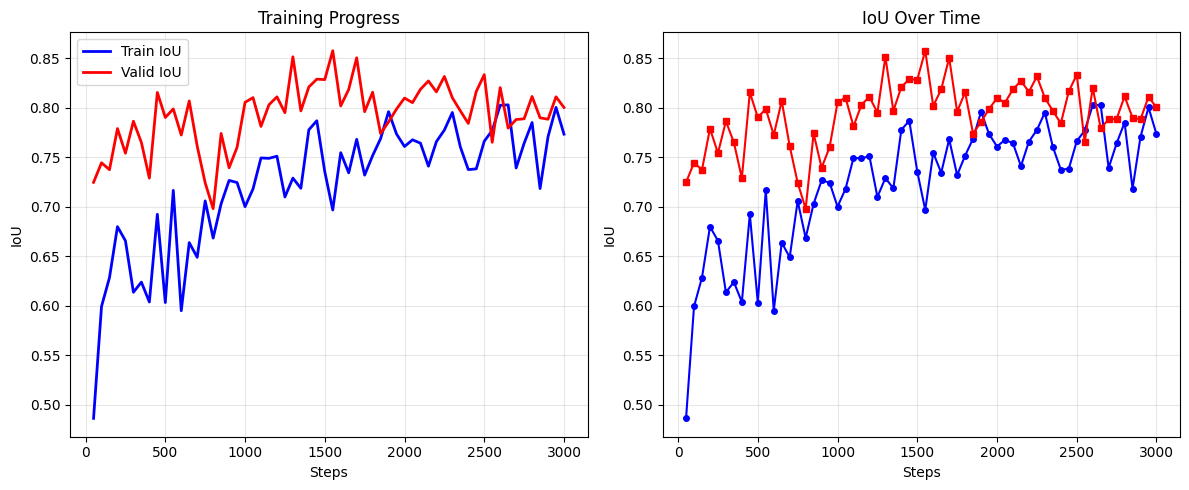


Final Train IoU: 0.7735
Final Valid IoU: 0.8004
Best Valid IoU: 0.8578


In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['steps'], history['train_iou'], 'b-', label='Train IoU', linewidth=2)
plt.plot(history['steps'], history['valid_iou'], 'r-', label='Valid IoU', linewidth=2)
plt.xlabel('Steps')
plt.ylabel('IoU')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['steps'], history['train_iou'], 'b-o', markersize=4)
plt.plot(history['steps'], history['valid_iou'], 'r-s', markersize=4)
plt.xlabel('Steps')
plt.ylabel('IoU')
plt.title('IoU Over Time')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

print(f"\nFinal Train IoU: {history['train_iou'][-1]:.4f}")
print(f"Final Valid IoU: {history['valid_iou'][-1]:.4f}")
print(f"Best Valid IoU: {max(history['valid_iou']):.4f}")

In [25]:
def predict_field(predictor, image_path, points, config):
    """ทำนาย segmentation"""
    
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize
    h, w = image.shape[:2]
    scale = min(1024 / w, 1024 / h)
    new_w, new_h = int(w * scale), int(h * scale)
    image_resized = cv2.resize(image, (new_w, new_h))
    
    # Scale points
    points_scaled = np.array(points) * scale
    
    with torch.no_grad():
        predictor.set_image(image_resized)
        
        input_points = points_scaled[:, np.newaxis, :]
        input_labels = np.ones((len(points_scaled), 1))
        
        masks, scores, _ = predictor.predict(
            point_coords=input_points,
            point_labels=input_labels
        )
    
    return image_resized, masks, scores, points_scaled

print("Inference function defined!")

Inference function defined!


In [26]:
# Load best model
print("Loading best model...")
sam2_model = build_sam2(config.MODEL_CFG, config.SAM2_CHECKPOINT, device=config.DEVICE)
predictor_test = SAM2ImagePredictor(sam2_model)
predictor_test.model.load_state_dict(torch.load(f"{config.MODEL_NAME}_best.pt"))
predictor_test.model.eval()
print("Model loaded!")

Loading best model...
Model loaded!


Testing on validation samples...

Sample 1:


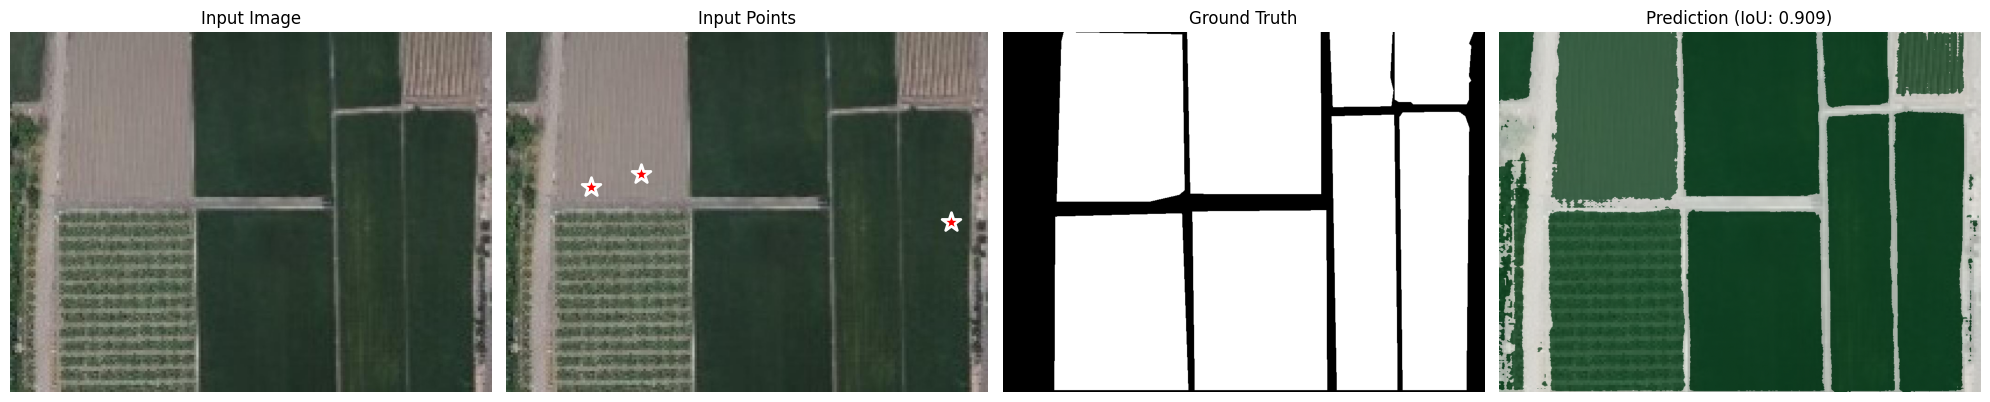


Sample 2:


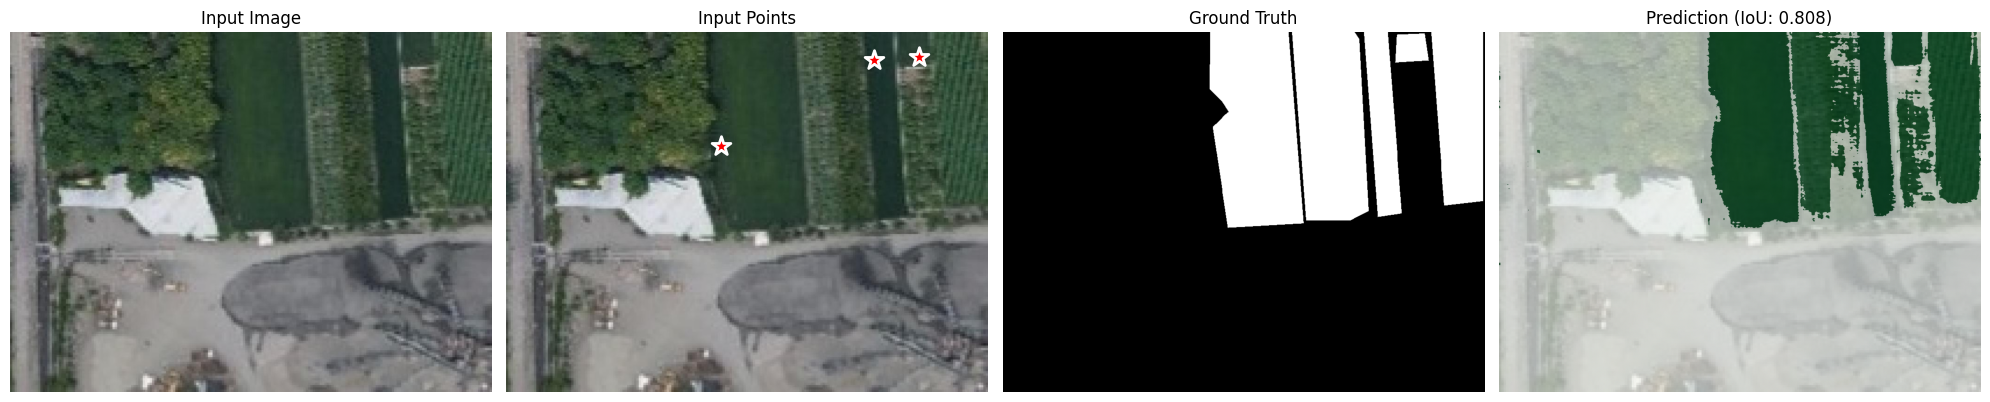


Sample 3:


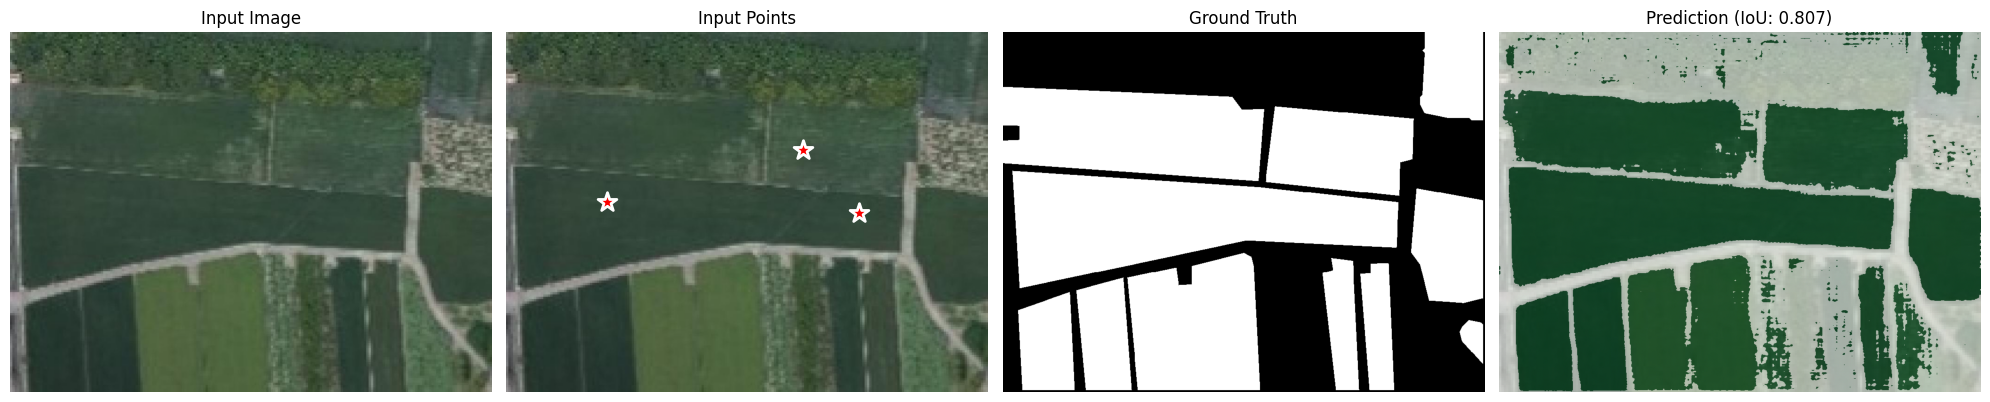


Sample 4:


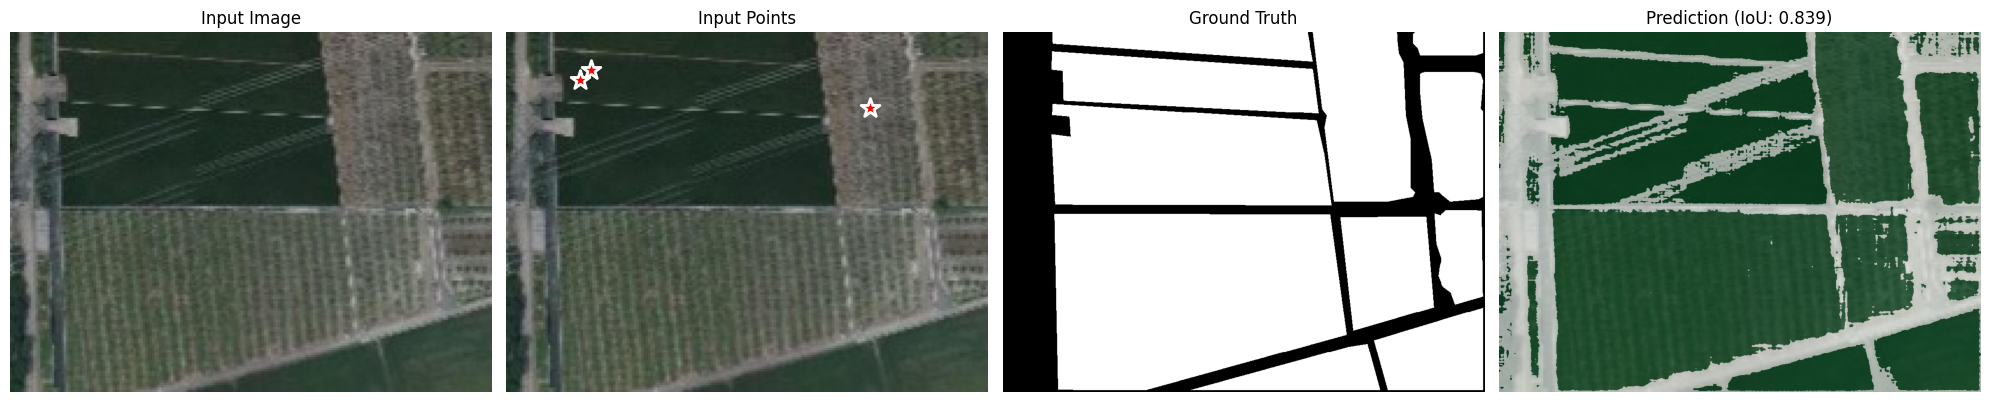


Sample 5:


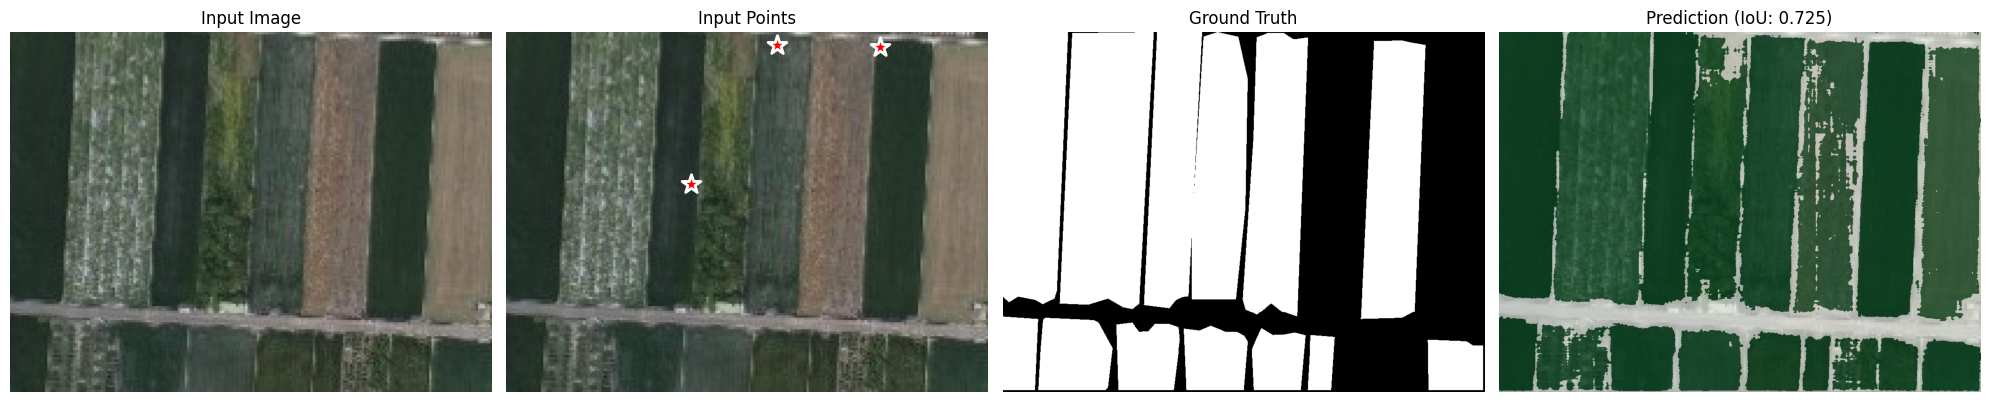


Average IoU on test samples: 0.8175


In [27]:
def test_on_sample(predictor, dataset, config):
    """ทดสอบบน 1 sample และแสดงผล"""
    
    image, gt_mask, points, num_points = dataset.get_sample()
    
    if image is None:
        print("Could not load sample")
        return
    
    with torch.no_grad():
        labels = np.ones((num_points, 1))
        
        predictor.set_image(image)
        
        input_points = points
        input_labels = labels
        
        masks, scores, _ = predictor.predict(
            point_coords=input_points,
            point_labels=input_labels
        )
    
    # Get best mask
    best_idx = np.argmax(scores[:, 0])
    pred_mask = masks[best_idx, 0]
    
    # Calculate IoU
    intersection = np.logical_and(gt_mask[0] > 0, pred_mask > 0).sum()
    union = np.logical_or(gt_mask[0] > 0, pred_mask > 0).sum()
    iou = intersection / (union + 1e-6)
    
    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(image)
    axes[0].set_title("Input Image")
    axes[0].axis('off')
    
    axes[1].imshow(image)
    points_2d = points[:, 0, :]
    for pt in points_2d:
        axes[1].scatter(pt[0], pt[1], c='red', s=200, marker='*',
                       edgecolors='white', linewidths=2)
    axes[1].set_title("Input Points")
    axes[1].axis('off')
    
    axes[2].imshow(gt_mask[0], cmap='gray')
    axes[2].set_title("Ground Truth")
    axes[2].axis('off')
    
    axes[3].imshow(image)
    axes[3].imshow(pred_mask, alpha=0.6, cmap='Greens')
    axes[3].set_title(f"Prediction (IoU: {iou:.3f})")
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return iou

# ทดสอบ 5 samples
print("Testing on validation samples...")
print("=" * 50)
ious = []
for i in range(5):
    print(f"\nSample {i+1}:")
    iou = test_on_sample(predictor_test, valid_dataset, config)
    if iou:
        ious.append(iou)

print("\n" + "=" * 50)
print(f"Average IoU on test samples: {np.mean(ious):.4f}")